# Finance news scraper from FinViz
#### I will be using FinViz website for data sourcing https://finviz.com/
#### Finviz includes all information required for stock analysis: fundamental ratios, news headlines and technical indicators
#### For e.g. to get the news headline for Apple from Finviz use the link: https://finviz.com/quote.ashx?t=AAPL. Note ticker AAPL. Replace it with ticker for other company to get their news

## Process
#### Step 1: Read the ticker.csv to get the tickers for which data needs to be pulled
#### Step 2: Scrape the FizWiz website to get news headlines for each ticker
#### Step 3: Create a csv file that includes ticker, date, time and news headline
#### Step 4: Save the csv file with name: finviz_news_<date> as its name

## 1. Import Libraries Required
#### 1. Requests to get data from FinViz
#### 2. BeautifulSoup to parse data from FinViz
#### 3. pandas to read the data from csv, process data and write to csv
#### 4. datetime to get date. This will be appended to file name
#### 5. csv to write csv file
#### 6. Time to wait between requests

In [1]:
# Import libraries
import urllib
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime
import csv
import time

## 2. Understand FinViz html and identify important tags that will be used to pull news data
### Steps to source news example on APPLE stock
#### Step 1: Go to the link: https://finviz.com/quote.ashx?t=AAPL and move the section where news is present on the page
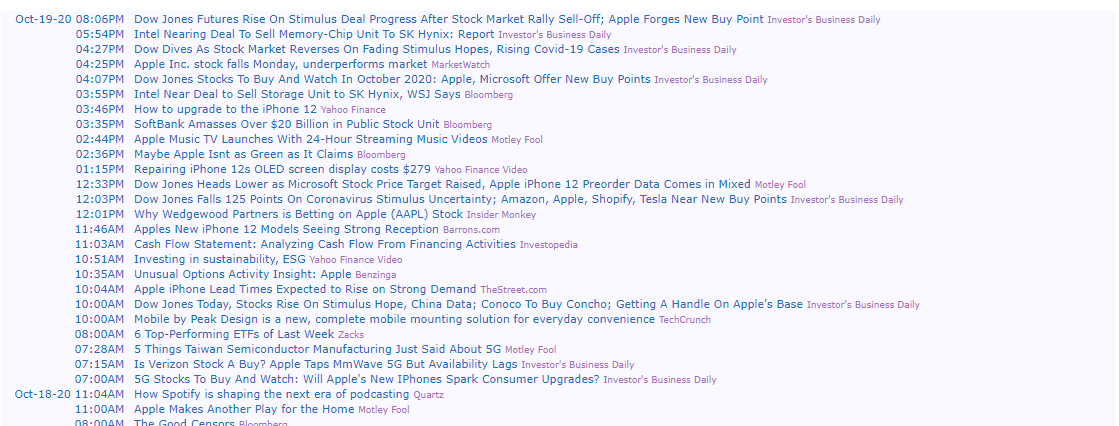
#### Step 2: Right click to inspect the html
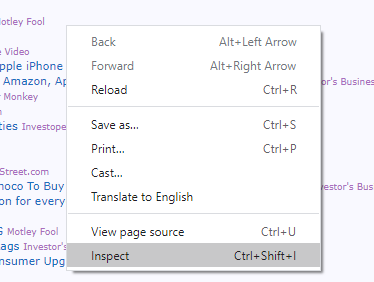
#### Step 3: On the inspect search for id="news-table". You will notice that news is stored in a table
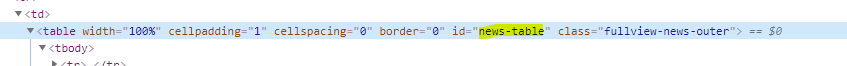
#### Step 4: On the inspect search for td tag that has date and time. Note tag needs to have date and time. There are some tags that has only time. This is because only 1st news tag has date. Rest all has only time with them.
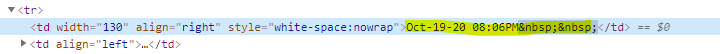
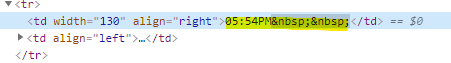
#### Step 5: On the inspect search for tag a with class="tab-link-news" that has news headline
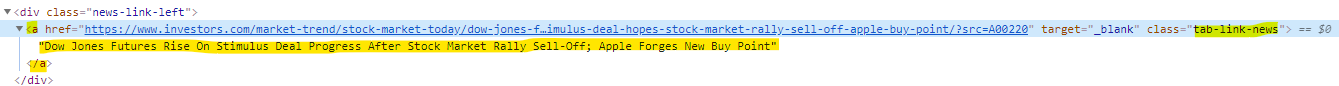

## Read the tickers from ticker.csv file to identify stocks for which news needs to be pulled
### Process to read ticker file and create list of tickers
#### Step 1: Open the csv file
#### Step 2: read the csv file in pandas data frame
#### Step 3: save the ticker in a list

In [2]:
ticker_data = pd.read_csv("S&P500Tickers.csv") # Open csv file and read data in pandas dataframe
ticker_data.head() # Display data to check correctness of data import
tickers_list = ticker_data['Symbol'].tolist() #Get all the tickers in a list

## 3. Pull the data and store it in a python dictionary where key is ticker and value is html pulled from FinViz
### Process 
#### Step 1: for each ticker in the tickers list: read the html using beautifulsoap
#### Step 2: Save the read html in the python dictionary where key is the ticker symbol and value is html data pulled

In [3]:
html_dict = {} # Dictionary that contains html for each ticker
url_finviz = 'https://finviz.com/quote.ashx?t='

for ticker in tickers_list:
    news_url = url_finviz + ticker
    request_object = Request(url=news_url,headers={'user-agent': 'Mozilla/5.0'}) # Creating request object
    try:
        response_object = urlopen(request_object)   # Open the request object to get the response object which is like a file 
        html_content = BeautifulSoup(response_object)  # Read the contents of the file 

        html_news_table = html_content.find(id='news-table') # Find 'news-table' id in the Soup and load it into a varaible
        html_dict[ticker] = html_news_table  # Add the html table to the dictionary html_dict
        #time.sleep(.5)
    #except urllib.error.HTTPError as err:
    except Exception as e:
        pass

In [4]:
## 5. Data parsing to get date, time and news headline
### Understanding code block
#### Step 1: 1st loop is on dictionary to get the key value pairs. Key is the company ticker and value is the data extracted from HTML for company news
#### Step 2: Run 2nd loop on each <tr> tag in the html stored in the dictionary value.
    #### Note:
    #### a. Each tr has tb that has time, only first tr has both date and time. rest all tr has time
    #### b. In each <tr> there is <td> that has <div> which has <a>. This <a> has the news title and its link. We are only interested in news title
#### Step 3: Get the news headline from <a> only and store it in a variable
#### Step 4: Split ear <tr> on <td> to get date and time. Note only one <td> for the day will give both date and time. Rest all will only give time
#### Step 5: if length of the split is 1 then it is only time else it has both date and time
#### Step 6: Extract the name of the ticker from the ticker
#### Step 7: Create a unique list that includes ticker, date, time and news headline. This list will be saved in parsed news to create list of listb

In [5]:
# Prase the html data in dictionary to get date, time and headlines. This will be stored in Python list that will be further writen in csv file
clean_news = []
# loop through keys (ticker) abd values (html table) of dictionary
for ticker, html_news_table in html_dict.items():
    # Note in the html table headline and date information is present in tr tag. Loop through tr tag
    for t in html_news_table.findAll('tr'):
        # In each tr there is <a> element which includes news headline. Get text from <a>
        headline = t.a.get_text() 
        # In <tr> there is <td> tag. The text in <td> tag includes date and time
        news_datetime = t.td.text
        news_datetime = news_datetime.strip().split() ## Strip spaces from the news and split
        
        # As mentioned earlier 1st article of news has both date and time. Rest all has only time. Thus, if lenght after split is 1 then only time. Oherwise both date and time
        if len(news_datetime) == 1:
            news_time = news_datetime[0]
        else:
            news_date = news_datetime[0]
            news_time = news_datetime[1]
        
        # Append ticker, date, time and headline as a list to list
        clean_news.append([ticker, news_date, news_time, headline])
        
# file name to write ending in today's date in YYYY-MM-DD
file_name = 'finviz_news_'+str(datetime.today()).split()[0] +'.csv'
file = open(file_name, 'w+', newline ='') # opening the csv file in 'w+' mode 
# writing the data into the file 
with file:     
    write = csv.writer(file) 
    write.writerows(clean_news) 
        
# Uncomment below to understand what is included in parsed list
#clean_news

[['A',
  'Oct-26-20',
  '06:15PM',
  "Bill Ackman Reduces Lowe's, Agilent Technologies and Hilton Worldwide Holdings"],
 ['A',
  'Oct-23-20',
  '06:17AM',
  "If You Had Bought Agilent Technologies (NYSE:A) Shares Five Years Ago You'd Have Earned 183% Returns"],
 ['A',
  'Oct-19-20',
  '07:38AM',
  'Agilent to Showcase Their Commitment to Sustainability at analytica virtual 2020'],
 ['A',
  'Oct-15-20',
  '08:00AM',
  'Agilent Vaya Raman Raw Material ID Verification System Receives 2020 R&D 100 Award'],
 ['A',
  'Oct-14-20',
  '08:00AM',
  'Agilent Early Career Professor Award Presented to Carl DeSelm'],
 ['A',
  'Oct-08-20',
  '10:32AM',
  'Agilent Announces the Availability of Objective Decision Support for Pathologists Reviewing Breast Cancer Cases'],
 ['A',
  'Oct-07-20',
  '04:44PM',
  'Dow Jones Rises 530 Points On Stimulus Hopes; Several Leading Stocks Break Out'],
 ['A',
  'Sep-30-20',
  '09:41AM',
  'Nike, OrganiGram, Thermo Fisher, Danaher Corp and Agilent Tech highlighted as 